In [26]:
import sys, os, json
from scf_guess_tools import Backend
import numpy as np
sys.path.append('../src/')
from scf_guess_datasets import Qm9Isomeres, Qm9IsomeresMd, Qm9
import matplotlib.pyplot as plt
from uncertainties import ufloat
import scf_guess_datasets, pickle
from utils import find_repo_root
project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)

BASIS_PATH = os.path.join(project_root_dir, "scripts/6-31g_2df_p_custom_nwchem.gbs")

Project root directory: /home/etschgi1/REPOS/Masterarbeit


In [27]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9")
isomers = Qm9Isomeres(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1,
)
isomers_md = Qm9IsomeresMd(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1,
)
qm9 = Qm9(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1,
)

In [28]:
def energy_elec(fock, density, coreH): 
    return np.trace((fock+coreH) @ density)

def energy_err(e_pred, e_conv): 
    return e_conv - e_pred, e_pred/e_conv -1

In [35]:
def eval_py_scf_guesses(dataset: scf_guess_datasets.Qm9Isomeres | scf_guess_datasets.Qm9IsomeresMd | scf_guess_datasets.Qm9):
    
    #energy
    rel_e_all = {}
    for scheme in dataset.schemes:
        e, rel_e = [], []
        for test_key in dataset.test_keys:
            guess_sample = dataset.guesses(test_key)[scheme]
            sol_sample = dataset.solution(test_key)
            e_pred = np.trace((guess_sample.fock + guess_sample.hcore) @ sol_sample.overlap)
            e_conv = np.trace((sol_sample.fock + sol_sample.hcore) @ sol_sample.overlap)
            e.append(energy_err(e_pred, e_conv)[0])
            rel_e.append(energy_err(e_pred, e_conv)[1])
        e = (np.mean(e), np.std(e))
        rel_e = (np.mean(rel_e), np.std(rel_e))
        rel_e_all[scheme] = rel_e 
        print(f"Scheme: {scheme}, Energy Error: {e},  Relative Energy Error: {rel_e}")
    plt.figure(figsize=(10, 6))
    bins = np.linspace(0, max(max(vals) for vals in rel_e_all.values()), 20)

    for scheme in dataset.schemes:
        plt.hist(rel_e_all[scheme], bins=bins, alpha=0.5, label=scheme)

    plt.xlabel("Relative Energy Error")
    plt.ylabel("Count")
    plt.title("Relative Energy Error Distribution per Scheme")
    plt.legend()
    plt.grid(True, alpha=0.3)


Dataset: qm9_isomeres
Scheme: 1e, Energy Error: (-1179.8415956693698, 128.05698098422806),  Relative Energy Error: (-0.12790142059844817, 0.011943862217614365)
Scheme: vsap, Energy Error: (-226.95565794401824, 23.642653466420526),  Relative Energy Error: (-0.024556318558674895, 0.0015923209133928292)
Scheme: sap, Energy Error: (-340.01292130308735, 50.148833962487856),  Relative Energy Error: (-0.036819947708232714, 0.004884546543600767)
Scheme: minao, Energy Error: (51.76204972206015, 3.318814873819838),  Relative Energy Error: (0.005616452711030502, 0.0003009631854660951)
Dataset: qm9_isomeres_md
Scheme: 1e, Energy Error: (-1311.4380950635646, 128.63696975861),  Relative Energy Error: (-0.13805189054929173, 0.010430383302097746)
Scheme: vsap, Energy Error: (-251.90761569155075, 26.187621996474103),  Relative Energy Error: (-0.02648079578540276, 0.001711354524784129)
Scheme: sap, Energy Error: (-376.538569385914, 51.09838753233788),  Relative Energy Error: (-0.03959934488312264, 0.004

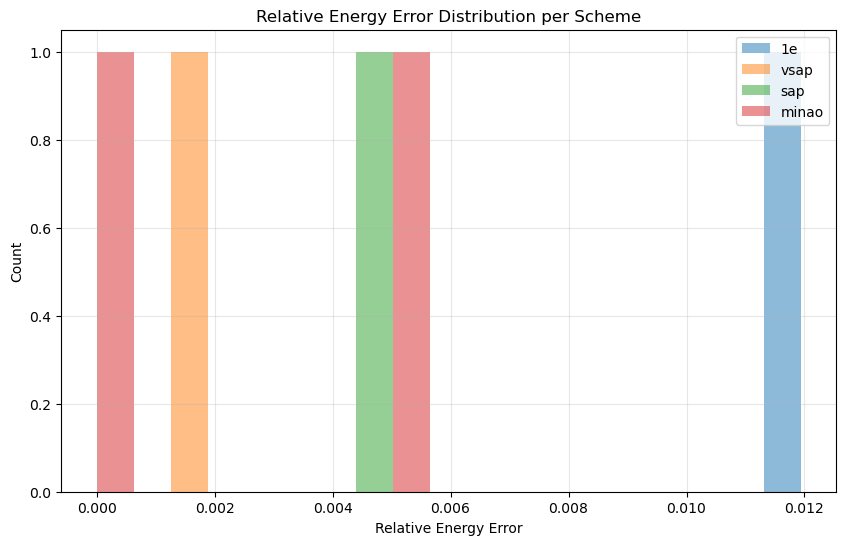

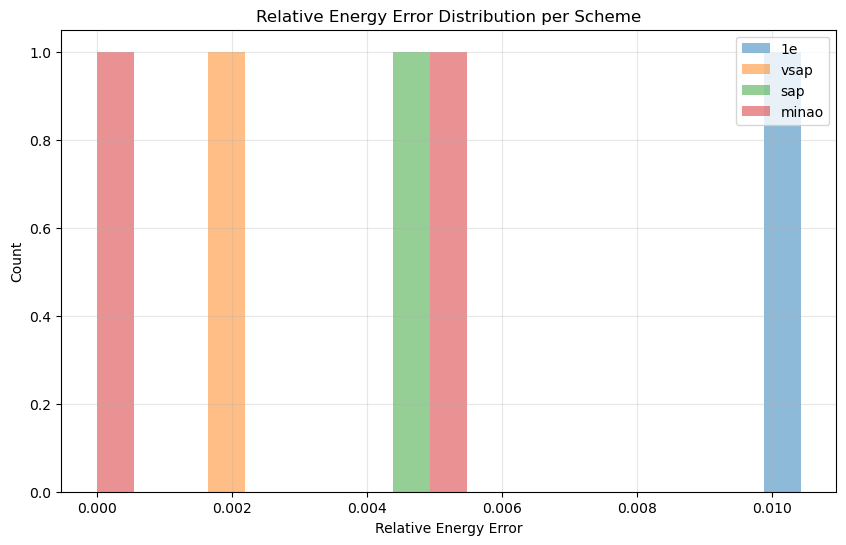

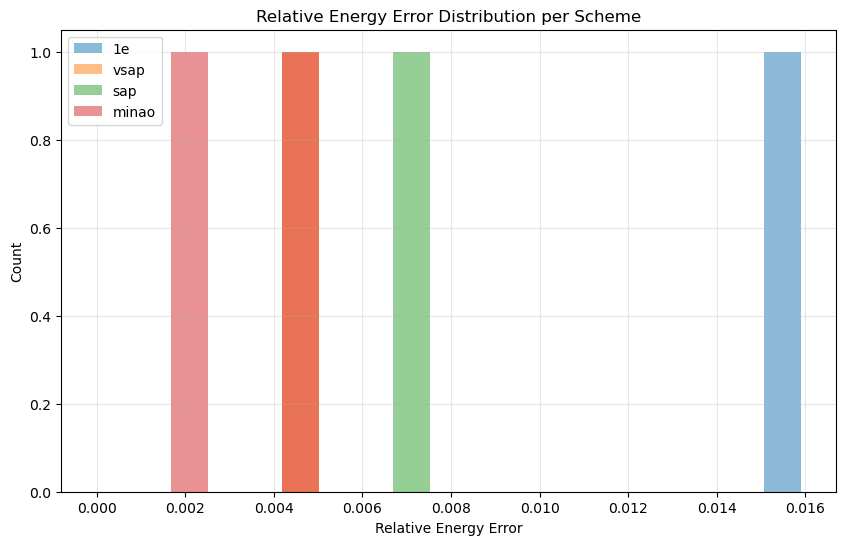

In [36]:

for dataset in [isomers, isomers_md, qm9]:
    print("================================")
    print(f"Dataset: {dataset.name}")
    eval_py_scf_guesses(dataset)
    